<a href="https://colab.research.google.com/github/abarb2022/Walmart-Recruiting---Store-Sales-Forecasting/blob/main/loading_kaggle_data_to_colab%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading Kaggle data sets directly into Colab**

Install the kaggle python library

In [1]:
! pip install kaggle

Mount the Google drive so you can store your kaggle API credentials for future use

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a directory for kaggle at the temporary instance location on Colab drive.

Download your kaggle API key (.json file). You can do this by going to your kaggle account page and clicking 'Create new API token' under the API section.

In [3]:
! mkdir ~/.kaggle

If you want to copy the kaggle API credentials to the temporary location... (I recommend placing it on your Google Drive)

In [4]:
#! cp kaggle.json ~/.kaggle/

Upload the json file to Google Drive and then copy to the temporary location.

In [5]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

**Competitions and Datasets are the two types of Kaggle data**

**1. Download competition data**

If you get 403 Forbidden error, you need to click 'Late Submission' on the Kaggle page for that competition.

In [7]:
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 689MB/s]


Unzip, in case the downloaded file is zipped. Refresh the files on the left hand side to update the view.

In [8]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [22]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder # For Type encoding if not using category dtype directly
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import gc # For garbage collection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

In [20]:

stores = pd.read_csv('stores.csv')
train = pd.read_csv("train.csv.zip")
features = pd.read_csv('features.csv.zip')
sample = pd.read_csv('sampleSubmission.csv.zip')
test = pd.read_csv('test.csv.zip')

In [21]:
# Convert 'Date' columns to datetime objects for easier manipulation
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Merge features with train and test data.
# Note: 'IsHoliday' is present in both train/test and features.csv.
# We'll merge on it to ensure consistency, but if there were discrepancies,
# we'd need a more careful merge strategy.
train_df = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')
test_df = pd.merge(test, features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Merge store information
train_df = pd.merge(train_df, stores, on='Store', how='left')
test_df = pd.merge(test_df, stores, on='Store', how='left')

print("\n--- Merged Train Data Head ---")
print(train_df.head())
print("\n--- Merged Test Data Head ---")
print(test_df.head())

print("\n--- Merged Train Data Info ---")
print(train_df.info())
print("\n--- Merged Test Data Info ---")
print(test_df.info())

# Free up memory
del train, test, features, stores
gc.collect()


--- Merged Train Data Head ---
   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type    Size
0      1     1 2010-02-05      24924.50      False        42.31       2.572        NaN        NaN        NaN        NaN        NaN  211.096358         8.106    A  151315
1      1     1 2010-02-12      46039.49       True        38.51       2.548        NaN        NaN        NaN        NaN        NaN  211.242170         8.106    A  151315
2      1     1 2010-02-19      41595.55      False        39.93       2.514        NaN        NaN        NaN        NaN        NaN  211.289143         8.106    A  151315
3      1     1 2010-02-26      19403.54      False        46.63       2.561        NaN        NaN        NaN        NaN        NaN  211.319643         8.106    A  151315
4      1     1 2010-03-05      21827.90      False        46.50       2.625        NaN        NaN        NaN        Na

8

## **DATA CLEANING**


In [25]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to handle missing values for specific columns.
    - MarkDown columns: fill with 0.
    - Other specified numerical columns: fill with ffill then bfill, fallback to mean.
    """
    def __init__(self, markdown_cols=None, numerical_cols_to_impute=None):
        self.markdown_cols = markdown_cols if markdown_cols is not None else [f'MarkDown{i}' for i in range(1, 6)]
        self.numerical_cols_to_impute = numerical_cols_to_impute if numerical_cols_to_impute is not None else ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
        self.means = {} # To store means for fallback imputation during transform

    def fit(self, X, y=None):
        # Calculate means for fallback imputation from the training data
        for col in self.numerical_cols_to_impute:
            if col in X.columns:
                self.means[col] = X[col].mean()
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Impute MarkDown columns with 0
        for col in self.markdown_cols:
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].fillna(0)

        # Impute other numerical columns with ffill then bfill, fallback to mean
        for col in self.numerical_cols_to_impute:
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].fillna(method='ffill').fillna(method='bfill')
                # Fallback to mean if NaNs still exist (e.g., if all values were NaN in a column)
                if X_copy[col].isnull().any() and col in self.means:
                    X_copy[col] = X_copy[col].fillna(self.means[col])
        return X_copy

In [26]:
class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to extract temporal features from the 'Date' column.
    """
    def __init__(self, date_column='Date'):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        if self.date_column not in X_copy.columns:
            raise ValueError(f"Date column '{self.date_column}' not found in DataFrame.")

        X_copy[self.date_column] = pd.to_datetime(X_copy[self.date_column])

        X_copy['Year'] = X_copy[self.date_column].dt.year
        X_copy['Month'] = X_copy[self.date_column].dt.month
        # Using .dt.isocalendar().week for consistent week numbering across years
        X_copy['Week'] = X_copy[self.date_column].dt.isocalendar().week.astype(int)
        X_copy['Day'] = X_copy[self.date_column].dt.day
        X_copy['DayOfWeek'] = X_copy[self.date_column].dt.dayofweek

        # Convert IsHoliday to integer if it exists and is boolean
        if 'IsHoliday' in X_copy.columns and X_copy['IsHoliday'].dtype == bool:
            X_copy['IsHoliday'] = X_copy['IsHoliday'].astype(int)

        return X_copy.drop(columns=[self.date_column]) # Drop the original Date column


In [27]:
class CategoricalFeatureConverter(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to convert specified columns to 'category' dtype
    for LightGBM to handle them efficiently.
    """
    def __init__(self, categorical_cols=None):
        self.categorical_cols = categorical_cols if categorical_cols is not None else ['Store', 'Dept', 'Type']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.categorical_cols:
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].astype('category')
        return X_copy

In [29]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('date_features', DateFeatureExtractor(date_column='Date')),
    ('imputer', MissingValueImputer(
        markdown_cols=[f'MarkDown{i}' for i in range(1, 6)],
        numerical_cols_to_impute=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    )),
    ('categorical_converter', CategoricalFeatureConverter(categorical_cols=['Store', 'Dept', 'Type']))
])

print("\n--- Applying Preprocessing Pipeline to Train Data ---")
X_train_processed = preprocessing_pipeline.fit_transform(train_df.drop(columns=['Weekly_Sales', 'Id'], errors='ignore'))
y_train = train_df['Weekly_Sales']
# The 'Date' column is dropped by DateFeatureExtractor, so it won't be in X_train_processed.

print("\n--- Applying Preprocessing Pipeline to Test Data ---")
# For the test set, we only call transform, as fit was done on the training data.
X_test_processed = preprocessing_pipeline.transform(test_df.drop(columns=['Id'], errors='ignore'))

print("\nProcessed X_train_processed info:")
print(X_train_processed.info())
print("\nProcessed X_test_processed info:")
print(X_test_processed.info())

# Verify no missing values in processed data
print("\nMissing values in processed X_train_processed:\n", X_train_processed.isnull().sum().sum())
print("Missing values in processed X_test_processed:\n", X_test_processed.isnull().sum().sum())

# Get feature names after preprocessing
features_after_pipeline = X_train_processed.columns.tolist()
categorical_features_after_pipeline = [col for col in ['Store', 'Dept', 'Type'] if col in features_after_pipeline]

# Prepare weights for training (this is typically outside the main feature pipeline)
# We need the 'IsHoliday' column which is now an integer from DateFeatureExtractor
train_weights = np.where(X_train_processed['IsHoliday'] == 1, 5, 1)

# Store test IDs for submission
test_ids = test_df['Store'].astype(str) + '_' + test_df['Dept'].astype(str) + '_' + test_df['Date'].dt.strftime('%Y-%m-%d')




--- Applying Preprocessing Pipeline to Train Data ---


/tmp/ipython-input-25-2176250721.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_copy[col] = X_copy[col].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-25-2176250721.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_copy[col] = X_copy[col].fillna(method='ffill').fillna(method='bfill')



--- Applying Preprocessing Pipeline to Test Data ---

Processed X_train_processed info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Store         421570 non-null  category
 1   Dept          421570 non-null  category
 2   IsHoliday     421570 non-null  int64   
 3   Temperature   421570 non-null  float64 
 4   Fuel_Price    421570 non-null  float64 
 5   MarkDown1     421570 non-null  float64 
 6   MarkDown2     421570 non-null  float64 
 7   MarkDown3     421570 non-null  float64 
 8   MarkDown4     421570 non-null  float64 
 9   MarkDown5     421570 non-null  float64 
 10  CPI           421570 non-null  float64 
 11  Unemployment  421570 non-null  float64 
 12  Type          421570 non-null  category
 13  Size          421570 non-null  int64   
 14  Year          421570 non-null  int32   
 15  Month         421570 non-null 

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [31]:
# Sort processed data by date for proper time-series splitting
# We need to re-attach Date for splitting
temp_train_df = X_train_processed.copy()
temp_train_df['Date'] = pd.to_datetime(train_df['Date']) # Get original dates back for sorting
temp_train_df['Weekly_Sales'] = y_train

temp_train_df = temp_train_df.sort_values(by='Date').reset_index(drop=True)

# Define a cutoff date for validation
validation_cutoff_date = pd.to_datetime('2012-09-01')

X_train_split = temp_train_df[temp_train_df['Date'] < validation_cutoff_date][features_after_pipeline]
y_train_split = temp_train_df[temp_train_df['Date'] < validation_cutoff_date]['Weekly_Sales']

X_val_split = temp_train_df[temp_train_df['Date'] >= validation_cutoff_date][features_after_pipeline]
y_val_split = temp_train_df[temp_train_df['Date'] >= validation_cutoff_date]['Weekly_Sales']



print(f"\nTrain split shape: {X_train_split.shape}, Val split shape: {X_val_split.shape}")

# LightGBM Model Parameters
lgb_params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 64,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
    'max_depth': -1,
}

# Create LightGBM model
model = lgb.LGBMRegressor(**lgb_params)

print("\n--- Training LightGBM Model ---")
model.fit(X_train_split, y_train_split,
          #sample_weight=weights_train_split,
          eval_set=[(X_val_split, y_val_split)],
          #eval_sample_weight=[weights_val_split],
          eval_metric='mae',
          callbacks=[lgb.early_stopping(50, verbose=True)],
          categorical_feature=categorical_features_after_pipeline
         )

print(f"\nBest iteration: {model.best_iteration_}")
#print(f"Best score on validation set (MAE): {model.best_score_['valid_0']['mae']:.4f}")




Train split shape: (397841, 19), Val split shape: (23729, 19)

--- Training LightGBM Model ---
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l1: 1591.83

Best iteration: 2000


KeyError: 'mae'

Custom WMAE on validation set: 1704.2529

--- Feature Importance ---


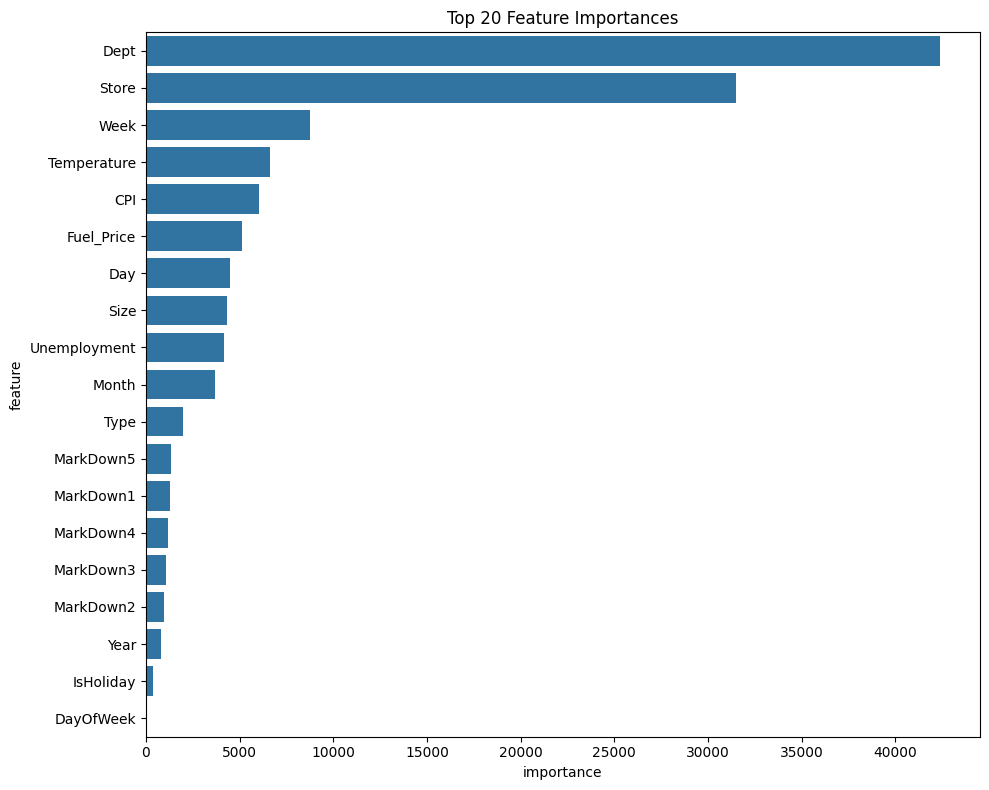

In [32]:

# Custom WMAE evaluation function
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

train_weights = np.where(X_val_split['IsHoliday'] == 1, 5, 1)

val_predictions = model.predict(X_val_split)
val_wmae = weighted_mean_absolute_error(y_val_split, val_predictions, train_weights)
print(f"Custom WMAE on validation set: {val_wmae:.4f}")

# --- Feature Importance Visualization ---
print("\n--- Feature Importance ---")
feature_importances = pd.DataFrame({'feature': X_train_split.columns, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()